In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [18]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [114]:
def altitude(t,dekl,phi,SHA):
    Alt = np.arcsin(np.cos(dekl * 2 * np.pi/360)*np.cos(phi* 2 * np.pi/360)* np.cos(t/24 * 2*np.pi +(SHA*np.pi*2)/(24*60)) + np.sin(dekl* 2 * np.pi/360)*np.sin(phi* 2 * np.pi/360))*360/(2*np.pi)
    return(Alt)
    
def Position_on_night_sky(N_pos_deg_input,N_pos_deg_sec,E_pos_deg,E_pos_deg_sec,Position_List,name_list,m,d,t_h,t_m):
    'sedirial time'
    #March 20 at noon it is att 0h0m0s
    #North position:N_pos
    #East position:E_pos
    #right ascention hour/min/sec: r_a_h,r_a_m,r_a_s
    #declination hour/min/sec:d_h
    #date month/day/hour/min: m,d,t_h,t_m
    
    #East position in minuites 
    
    E_pos_min = (E_pos_deg+E_pos_deg_sec/60) * 4 # (24h + 60 min) / 360 deg = 24/6 = 4
    N_pos_deg = N_pos_deg_input + N_pos_deg_sec/60 # from deg into min
    
    #date 
    month_array = [0,31,59,90,120,151,181,212,243,273,304,334]
    days_from_month = month_array[m-1]
    days_total = days_from_month + d-1 + (t_h +t_m/60)/24 # days from new year for the day we are looking at
    days_total_march = month_array[3-1] + 20-1 + 0.5 # days from new year for the 20 march
    difference_days =  days_total - days_total_march # day difference
    anlgle_in_min = difference_days * 4 + (t_h-12) * 60 +t_m #+ E_pos_min# angle in min as difference
    if anlgle_in_min < 0: # if the value is negative we have aczually a bigger one according to the definition
        VE_hour_angle = 24*60+anlgle_in_min 
    else :
        VE_hour_angle = anlgle_in_min
    Print1 = print("The sedirial time is %d min or %f h" % (VE_hour_angle,VE_hour_angle/60))
    print("-------------------------------------------------------------------------")
    Plt_list = []
    threeD_pos_list = []
    for i in range(len(Position_List)):
        print(name_list[i])
        Star_Pos_List = Position_List[i] #r_a_h,r_a_m,r_a_s,d_deg,d_deg_sec
        r_a_h = Star_Pos_List[0]
        r_a_m = Star_Pos_List[1]
        r_a_s = Star_Pos_List[2]
        d_deg = Star_Pos_List[3]
        d_deg_sec = Star_Pos_List[4]
        'calculate star position'
        Star_r_a_min = r_a_h*60 + r_a_m+ r_a_s/60 # star right ascension in min
        Star_hour_angle = VE_hour_angle-Star_r_a_min # star hour angle
        if Star_hour_angle < 0: # if the value is negative we have aczually a bigger one according to the definition
            Star_hour_angle = 24*60+Star_hour_angle 
        else :
            Star_hour_angle = Star_hour_angle
        Print2 = print("The hour angle of the star is %d min or %f deg" %(Star_hour_angle,Star_hour_angle/4) )#print out 2

        'calculate highest and lowest point'
        Star_d_deg = d_deg + d_deg_sec/60 #declination of start
        if N_pos_deg<=Star_d_deg:
            Highest_point =  90 -(Star_d_deg - N_pos_deg)
        else :
            Highest_point = 90 +(Star_d_deg - N_pos_deg) #recheck that!!1
        Lowest_point = Star_d_deg + N_pos_deg -90
        
        if  Highest_point - Lowest_point != 0.:
            if Highest_point < 0:
                Print3 = print("The highest point on the night sky is h = %f deg below the horizon. The object is NOT visible!" % Highest_point)
            else : 
                Print3 = print("The highest point on the night sky is h = %f deg above the horizon" % Highest_point)

            if Lowest_point < 0:
                Print4 = print("The lowest point on the night sky is h = %f deg below the horizon. The object is NOT visible!" % Lowest_point)
            else : 
                Print4 = print("The lowest point on the night sky is h = %f deg above the horizon" % Lowest_point) 
        else:
            print("You are at a pole. The highest/lowest point is %f deg" % Lowest_point)
        High = altitude(0,Star_d_deg,N_pos_deg,Star_hour_angle)
        t = np.arange(0.0, 24 , 12/100)
        plt.plot(t,altitude(t,Star_d_deg,N_pos_deg,Star_hour_angle),label=name_list[i])
        print("Altitude of the star is %f deg" % High)
        print("-------------------------------------------------------------------------")
        #claculate some plot stuff
        dekl = Star_d_deg*2*np.pi/360
        theta = 0.5*np.pi-dekl
        phi = np.linspace(-np.pi,  np.pi, 199)
        r = 1 
        zC1 = r *np.cos(theta)
        xC1 = r * np.sin(phi)*np.sin(theta)
        yC1 = r * np.cos(phi)*np.sin(theta)

        phi = N_pos_deg*np.pi*2/360
        alpha = 0.5* np.pi - phi
        yC = yC1
        xC = np.cos(alpha) * xC1 - np.sin(alpha) * zC1
        zC = np.cos(alpha) * zC1 + np.sin(alpha) * xC1
        threeD_pos_list.append([xC,yC,zC])
        
    time_list = np.append(np.arange(t_h +t_m/60,24,1),np.arange(0,t_h +t_m/60,1))
    reference_time_list = np.arange(0,24,1)
    plt.title("Altitude in Stockholm on 14/02, 6 pm")
    plt.xlabel("Time [h]")
    plt.ylabel("Altitude [deg]")
    plt.grid()
    plt.xticks(reference_time_list,time_list)
    plt.axvline(24-t_h +t_m/60, -90, 90, label='midnight',color="black")
    plt.axhline(0, 0, 24, label='horizontal line',color="black")
    plt.rcParams["figure.figsize"] = (20,10)
    plt.legend()
    plt.savefig("altitude_vs_time.png")
    
    #draw 3D
    fig = plt.figure(figsize=(12,12))

    ax = fig.gca(projection='3d')
    ax.set_aspect("auto")






    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:0.5*np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    
    ax.plot_wireframe(x, y, z, color="lightgrey")
    
    # draw a point
    ax.scatter([0], [0], [0], color="g", s=100,label = "A")  
    
    # draw a vector

    y_Arrow = 0
    x_Arrow = -np.sin(0.5*np.pi - 2*np.pi*N_pos_deg/360)*2
    z_Arrow = np.cos(alpha) * 2

    ax.arrow3D(0,0,0,x_Arrow,y_Arrow,z_Arrow,mutation_scale=20,arrowstyle="-|>",linestyle='dashed')


    
    for i in range(len(threeD_pos_list)):
        List_Loop = threeD_pos_list[i]
        ax.plot(List_Loop[0], List_Loop[1], List_Loop[2],label = name_list[i])
    plt.legend
    plt.savefig("Plot_3D_traces.pdf")

    
    

The sedirial time is 225 min or 3.750000 h
-------------------------------------------------------------------------
Sirius
The hour angle of the star is 1258 min or 314.625000 deg
The highest point on the night sky is h = 13.916667 deg above the horizon
The lowest point on the night sky is h = -47.383333 deg below the horizon. The object is NOT visible!
Altitude of the star is 5.465801 deg
-------------------------------------------------------------------------
Mimosa
The hour angle of the star is 896 min or 224.016667 deg
The highest point on the night sky is h = -29.150000 deg below the horizon. The object is NOT visible!
The lowest point on the night sky is h = -90.450000 deg below the horizon. The object is NOT visible!
Altitude of the star is -68.116869 deg
-------------------------------------------------------------------------
Albiero
The hour angle of the star is 493 min or 123.366667 deg
The highest point on the night sky is h = 58.650000 deg above the horizon
The lowest po

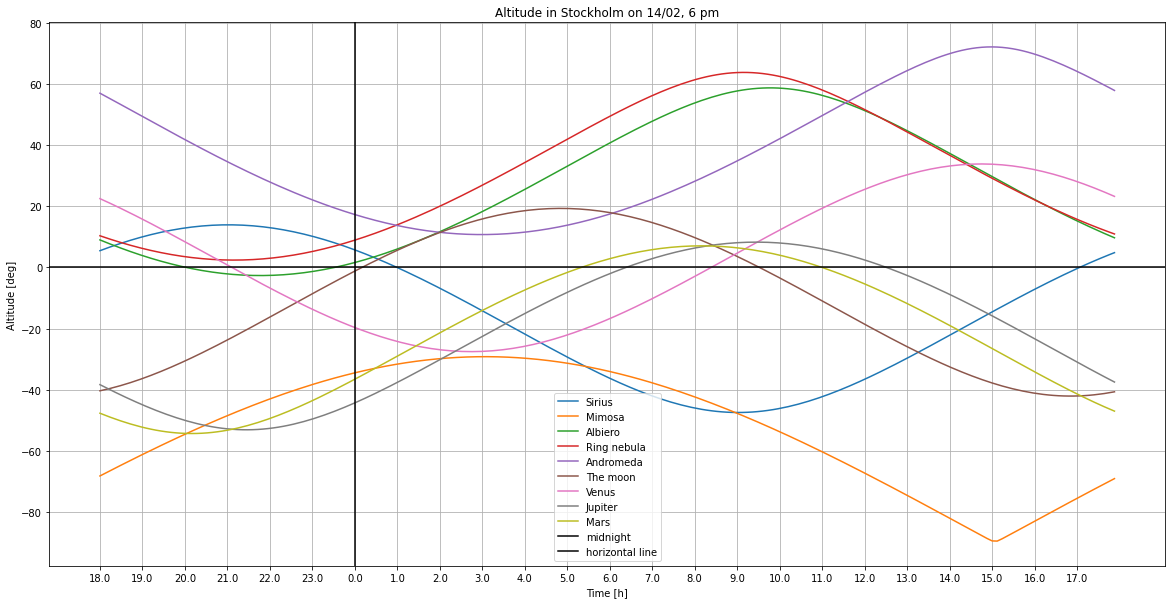

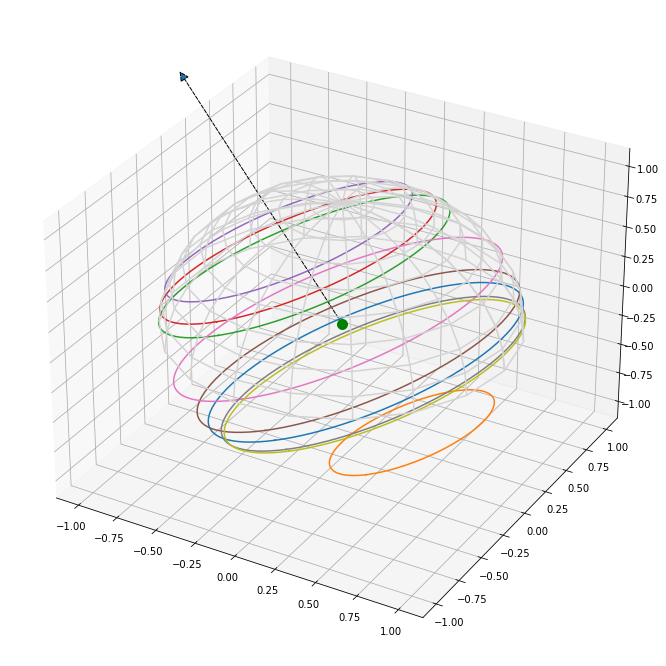

In [115]:
#Star Positions
Star_Positions_List = [[6,46,30,-16,-44],[12,48,56,-59,-48],[19,31,32,28,0],[18,54,20,33,3],[0,43,52,41,23],[14,35,45,-11,-22],[0,29,36,3,9],[19,11,54,-22,-23],[17,54,45,-23,-36]]
Name_List = ["Sirius","Mimosa","Albiero","Ring nebula","Andromeda","The moon","Venus","Jupiter","Mars"]
# Position_on_night_sky(N_pos_deg,N_pos_deg_sec,E_pos_deg,E_pos_deg_sec,[[r_a_h,r_a_m,r_a_s,d_deg,d_deg_sec],[..],...],[[red],[blue],...],m,d,t_h,t_m):
Position_on_night_sky(59,21,18,0,Star_Positions_List,Name_List,2,14,18,0)


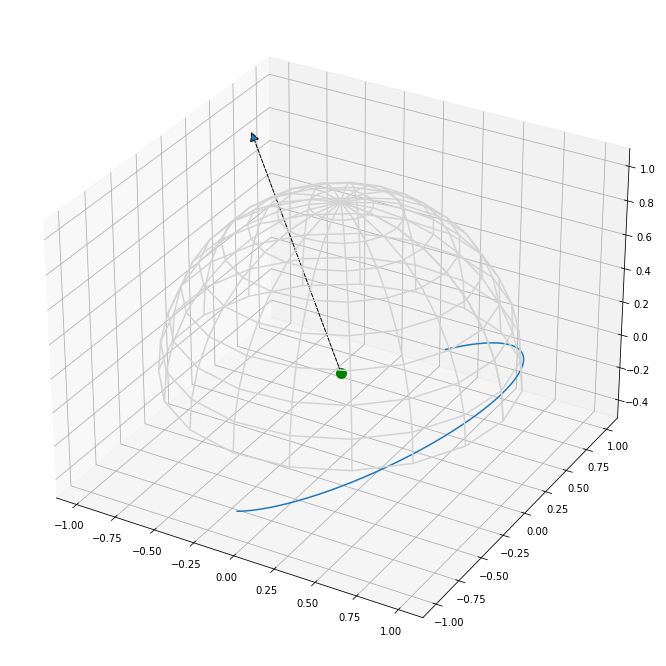

In [113]:

fig = plt.figure(figsize=(12,12))

ax = fig.gca(projection='3d')
ax.set_aspect("auto")


#draw circle 
dekl = -0.1*np.pi
theta = 0.5*np.pi-dekl
ax2 = fig.gca(projection='3d')
phi = np.linspace(0,  1.1*np.pi, 199)
r = 1 
zC1 = r *np.cos(theta)
xC1 = r * np.sin(phi)*np.sin(theta)
yC1 = r * np.cos(phi)*np.sin(theta)

phi = 0.35*np.pi
alpha = 0.5* np.pi - phi
yC = yC1
xC = np.cos(alpha) * xC1 - np.sin(alpha) * zC1
zC = np.cos(alpha) * zC1 + np.sin(alpha) * xC1



# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:0.5*np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

# draw a point
ax.scatter([0], [0], [0], color="g", s=100,label = "A")

# draw a vector

x_Arrow = 0
y_Arrow = -np.sin(alpha)*2
z_Arrow = np.cos(alpha) * 2

ax.arrow3D(0,0,0,x_Arrow,y_Arrow,z_Arrow,mutation_scale=20,arrowstyle="-|>",linestyle='dashed')



List_test = [[xC,yC,zC]]
Color_list = ["red","green"]
ax.plot_wireframe(x, y, z, color="lightgrey")
for i in range(len(List_test)):
    List_Loop = List_test[i]
    ax.plot(List_Loop[0], List_Loop[1], List_Loop[2])


plt.show()

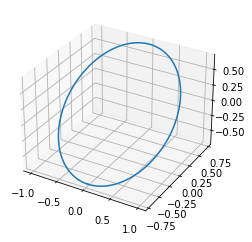

In [26]:
fig = plt.figure()
theta = 0.5*np.pi
ax2 = fig.gca(projection='3d')
phi = np.linspace(-np.pi,  np.pi, 199)
r = 1
zC1 = r *np.cos(theta)
xC1 = r * np.sin(phi)*np.sin(theta)
yC1 = r * np.cos(phi)*np.sin(theta)

alpha = 0.25 * np.pi
xC = xC1
yC = np.cos(alpha) * yC1 - np.sin(alpha) * zC1
zC = np.cos(alpha) * zC1 + np.sin(alpha) * yC1



# OUR ONE LINER ADDED HERE:
ax2.get_proj = lambda: np.dot(Axes3D.get_proj(ax2), np.diag([2, 2, 2, 2]))

ax2.plot(xC, yC, zC)
plt.show()

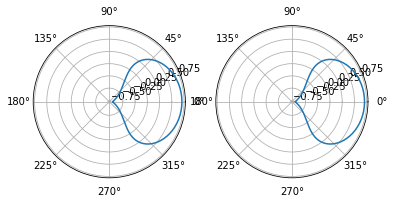

In [16]:
fig, (ax4, ax5) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))
# Some example data to display
ax4.plot(xC, yC)
ax5.plot(xC, zC)

plt.show()

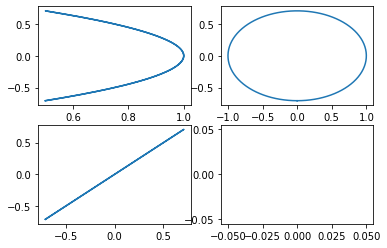

In [24]:
# Create some normally distributed data
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = xC,yC

# Set up the axes with gridspec
figure, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].plot(xC**2 + yC**2, zC)
axes[0, 1].plot(xC, zC)
axes[1, 0].plot(yC, zC)
axes[1, 1].plot()

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

In [58]:
len(np.append(np.arange(18 +0/60,24,12/100),np.arange(0,18 +0/60,12/100)))-len(np.arange(0.0, 24 , 12/100))

0